In [49]:
import numpy as np 
import scipy.stats as st 
from queue import *
import math
from distances import *
from statistics import mean 
import matplotlib.pyplot as plt


In [50]:

class Event: 
    def __init__( self, time ):
        self.time = time   
    def __lt__( self, other ):
        return self.time < other.time  
    def handle( self ):
        """updates the global simulation clock time to the class's current time attribute
        preconditions: none"""
        global simulationclock
        simulationclock = self.time
    
class NewRequest(Event, object): #An arrival occurs 
    def __init__( self, time):
        """creates a new object of class NewRequest and sets the class time attribute to the time argument
        Preconditions: time is the desired simulation clock time of the NewRequest"""
        super(NewRequest, self).__init__( time )
    def __lt__( self, other ):
        return self.time < other.time   
    def handle( self ):
   
        super(NewRequest, self).handle() # inherit operations in the function in the base class, simulation clock updated to the time when the arrival event occurs
        center = getBC()
        # request = Request(nextId, center, simulationclock, None )
        request = Request(center, simulationclock, None )
        # nextId += 1 
        eventlist.put( NewRequest( simulationclock + arrivaltime() ) )
        closest_mechanic_center, distance = closest_available_mechanic(request.center, bc_list)
        if closest_mechanic_center == None:
            requestQueue.append(request) 
        elif closest_mechanic_center == DispatchCenter: 
            DispatchCenter.num_mechs -= 1
            eventlist.put(mech_Arrives(simulationclock+(distance/60), request.center, request)) 
        else: 
            eventlist.put(mech_Arrives(simulationclock+(distance/60), request.center, request))
            closest_mechanic_center.free_mechanics -= 1
            closest_mechanic_center.number_of_mechanics -=1


class mech_Arrives(Event, object): 
    def __init__(self, time, business_center, request): 
        super(mech_Arrives, self).__init__(time)
        self.business_center = business_center
        self.request = request
    def __lt__( self, other ):
        return self.time < other.time  
    def handle(self):
        """update the global simulation time to the event time, schedule the end of the diagnosis for 
        diagnosis_time later, and increase the number of busy mechanics at the business center by 1"""
        super(mech_Arrives, self).handle()
        self.request.time_responded = (simulationclock - self.request.timeEntered)*60
        time_to_respond_avg.append(self.request.time_responded) if simulationclock>t else None
        diag_time = diagnosis_Time(self.business_center)
        self.business_center.number_of_mechanics += 1 
        eventlist.put(diag_ends(simulationclock+ diag_time, self.business_center))
        
        

class diag_ends(Event, object):
    def __init__(self, time, business_center):
        super(diag_ends, self).__init__(time)
        self.business_center = business_center
    def __lt__( self, other ):
        return self.time < other.time  
    def handle(self):
        super(diag_ends, self).handle()
        BC_prob = np.random.uniform(0,1)
        options = ['repair', 'replace']
        outcome_probabilities = np.array([0.8195, 0.1805])

        outcome = np.random.choice(options, 1, p = outcome_probabilities)[0]   
        if outcome == 'repair':
            eventlist.put(repair_start(simulationclock, self.business_center))
        else:
            eventlist.put(call_van(simulationclock, self.business_center))

class repair_start(Event, object): 
    def __init__(self, time, business_center): 
        super(repair_start, self).__init__(time)
        self.business_center = business_center
    def __lt__( self, other ):
        return self.time < other.time  
    def handle(self): 
        super().handle()
        repair_time = st.beta.rvs(2.6158007964976218, 7.460626334186162, -0.0077049330279426054, 1.557915557823419, size=1)[0]
        #repair_time = st.beta.rvs(3, 8, -0.0077049330279426054, 1.557915557823419, size=1)[0]
        #repair_time = st.rayleigh.rvs(0.0013399745442049282, 0.31486846900358867)
        eventlist.put(repair_end(simulationclock+ repair_time, self.business_center))


class repair_end(Event, object):
    def __init__(self, time, business_center): 
        super(repair_end, self).__init__(time)
        self.business_center = business_center
    def __lt__( self, other ):
        return self.time < other.time  
    def handle(self): 
        super(repair_end, self).handle()
        eventlist.put(mechanic_leaves_business_center(simulationclock, self.business_center))           

            
class mech_goes_to_dispatch(Event,object): 
    def __init__(self, time):
        super(mech_goes_to_dispatch,self).__init__(time)
    def __lt__( self, other ):
        return self.time < other.time  
    def handle(self):
        super(mech_goes_to_dispatch,self).handle()
        DispatchCenter.num_mechs += 1
        if len(requestQueue>0):
            req = requestQueue[0]
            requestQueue.remove(req)
            dist = distances.at['Dis', req.center.name]
            travel_time = dist/60
            eventlist.put(mech_Arrives(simulationclock+travel_time, req.center, req))
            DispatchCenter.num_mechs -= 1
            

        


####### REPLAACEMENT STARTS HERE
class call_van(Event,object):
    def __init__(self, time, business_center):
        super().__init__( time )
        self.business_center = business_center
    def handle(self):
        super(call_van,self).handle()
        copier_request =  Request(self.business_center, simulationclock, None)
        if DispatchCenter.available_vans > 0: 
            DispatchCenter.available_vans -= 1 
            dist = distances.at['Dis', copier_request.center.name]
            travel_time = dist/60
            eventlist.put(van_arrives_at_bc(simulationclock+travel_time, self.business_center, copier_request))           
        else:
            copierQueue.put(copier_request)
        eventlist.put(mechanic_leaves_business_center(simulationclock, self.business_center))           


class mechanic_leaves_business_center(Event, object):
    def __init__(self, time, business_center):
        super().__init__( time )
        self.business_center = business_center
    def handle(self):
        super(mechanic_leaves_business_center, self).handle()
        if len(requestQueue)==0:
            self.business_center.free_mechanics += 1
        else: 
            req = closest_request(self.business_center)
            dist = distances.at[req.center.name, self.business_center.name]
            travel_time = dist/60
            eventlist.put(mech_Arrives(simulationclock+travel_time, req.center, req))
            self.business_center.number_of_mechanics -= 1 

            
     
                
class van_arrives_at_bc(Event, object):
    def __init__(self, time, business_center, copier_request ):
        super().__init__( time )
        self.business_center = business_center
        self.copier_request = copier_request
    def handle(self):
        super(van_arrives_at_bc, self).handle()
        eventlist.put(van_returns_to_dispatch(simulationclock+swaptime_customer(), self.business_center, self.copier_request))
        


class van_returns_to_dispatch(Event, object):
    def __init__(self, time, business_center, copier_request):
        super().__init__(time)
        self.business_center = business_center
        self.copier_request = copier_request
    def handle(self):
        super(van_returns_to_dispatch, self).handle()
        self.copier_request.time_responded = (simulationclock - self.copier_request.timeEntered)*60
        copier_req_times.append(self.copier_request.time_responded) if simulationclock>t else None
        dist = distances.at['Dis', self.business_center.name]
        travel_time = dist/60 
        eventlist.put(van_swaps_copiers(simulationclock+travel_time))  

                      
class van_swaps_copiers(Event, object):
    def __init__(self, time):
        super().__init__(time)
    def handle(self):
        super(van_swaps_copiers, self).handle()
        eventlist.put(vans_finishes_swap(simulationclock + swaptime_dispatch()))
            
class vans_finishes_swap(Event, object):
    def __init__(self, time):
        super().__init__(time)
    def handle(self):
        super(vans_finishes_swap , self).handle()
        if copierQueue.empty():
            DispatchCenter.available_vans += 1
        else:
            cop_req = copierQueue.get()
            dist = distances.at['Dis', cop_req.center.name]
            travel_time = dist/60
            eventlist.put(van_arrives_at_bc(simulationclock+travel_time, cop_req.center, cop_req))
            

    

class Request(object): 
    def __init__( self, center, timeEntered, time_responded=None ):
        self.center = center
        # self.id = id      
        self.timeEntered = timeEntered
        self.time_responded = time_responded

def arrivaltime(): #Comes from input analysis question 6  
    global arrivalrate
    time_of_day = simulationclock%24
    if time_of_day < 22 and time_of_day >3: 
        arrivalrate = (-0.067*(time_of_day**2)) + 1.581*(time_of_day) - 1.289 
    else: 
        arrivalrate = 1.137 
    return np.random.exponential( 1 / arrivalrate )

def swaptime_dispatch(): #Service time to swap at the dispatch center, keeping everything in hours 
    return np.random.triangular(left=10/60, mode=15/60, right=25/60)

def swaptime_customer(): #Service time to swap at customer loctation 
    return np.random.triangular(left=20/60, mode=30/60, right = 1)
        
# def diagnosis_Time(bc):
#     if bc.name in ['BC_2', 'BC_3', 'BC_9']:
#         return 1/60*np.random.normal(16.13, 2.89)
#     else: 
#         return 1/60*np.random.normal(22.15, 5.34)


def closest_available_mechanic(business_center, bc_list):
    available_mechanic_centers = []
    for x in bc_list:
        if x.free_mechanics > 0:
            available_mechanic_centers.append(x)
    if len(available_mechanic_centers)==0 and DispatchCenter.num_mechs ==0:
        return None, None
        

    if len(available_mechanic_centers)==0:
        if DispatchCenter.num_mechs > 0:
            disp_dist = distances.at['Dis', business_center.name]
            return DispatchCenter, disp_dist

        
    
    min_dist_center = available_mechanic_centers[0]
    min_dist = distances.at[min_dist_center.name, business_center.name]

    for y in available_mechanic_centers:
        dist = distances.at[y.name, business_center.name]
        if dist < min_dist:
            min_dist = dist
            min_dist_center = y
    if DispatchCenter.num_mechs != 0:
        disp_dist = distances.at['Dis', business_center.name]
        if disp_dist < min_dist:
            min_dist = disp_dist
            min_dist_center = DispatchCenter
  
    return min_dist_center, min_dist


def closest_request(BC):
    closest_req=requestQueue[0]
    closest_dist=distances.at[BC.name, closest_req.center.name]
    for req in requestQueue:
        if distances.at[BC.name, req.center.name] < closest_dist:
            closest_dist=distances.at[BC.name, req.center.name]
            closest_req=req
    requestQueue.remove(closest_req)
    return closest_req



    

In [51]:
class business_center(object):
    def __init__( self, name, coordinates, number_of_mechanics=0, number_of_vans=0, free_mechanics=0):
        self.name=name
        self.coordinates = coordinates
        self.number_of_mechanics = number_of_mechanics
        self.number_of_vans = number_of_vans
        self.free_mechanics = free_mechanics

In [52]:
class van(object):
    def __init__( self, busy=False, current_location=0, broken=False):
        self.busy = busy
        self.current_location = current_location 
        self.broken = broken

In [53]:
class dispatch(object):
    def __init__(self, coordinates, available_vans, num_mechs):
        self.coordinates = coordinates
        self.available_vans = available_vans
        self.num_mechs = num_mechs


In [54]:
class mechanic(object):
    def __init__(self, busy=False, current_location=0):
        self.busy = busy
        self.current_location= current_location


In [56]:
bc_coords = [[6,10],[4,8],[4,6],[1,6],[1,7],[9,3],[11,3],[9,2],[9,1],[11,1]]
bc_names = ['BC_1', 'BC_2', 'BC_3', 'BC_4', 'BC_5', 'BC_6', 'BC_7', 'BC_8', 'BC_9', 'BC_10']

# bc_list = []
# for i in range(len(bc_coords)):
#     bc_list.append(business_center(bc_names[i], bc_coords[i] , 0, 0, 0))
def getBC():
    BC_prob = np.random.uniform(0,1)
    probabilities = np.array([0.039509, 0.082089, 0.107916, 0.135418, 0.118386, 
                              0.055005, 0.123830, 0.057937, 0.137512, 0.142398])
    return np.random.choice(bc_list, 1, p = probabilities)[0]



#mean and standard errors of the estimates
mec_avgs_mean1=[]
mec_se_std1=[]
van_avgs_mean1=[]
van_se_std1=[]
t=50
T=100
B=50
mu1=16.13
mu2=22.15
std1=2.89
std2=5.34

# ****SENSITIVITY ANALYSIS PART****
#Looping Through Perturbed Values 
std_adjusts=np.linspace(start= -1, stop=1, num=50)
std_array=[]
for j in std_adjusts:
    #copy in function that we want to look at
    def diagnosis_Time(bc):
        #Here we are altering the standard deviation values 
        if bc.name in ['BC_2', 'BC_3', 'BC_9']:
            return 1/60*np.random.normal(mu2, std2+j)
        else: 
            return 1/60*np.random.normal(mu1, std1-j)
    mec_avgs=[]
    van_avgs=[]
    for i in range(B):
        simulationclock = 0
        requestQueue = []
        copierQueue = Queue()
        avail_vans = 3
        num_mechs = 7
        DispatchCenter = dispatch([5,2], avail_vans, num_mechs)
        eventlist = PriorityQueue()
        bc_list = []
        for i in range(len(bc_coords)):
            bc_list.append(business_center(bc_names[i], bc_coords[i] , 0, 0, 0))
        a = NewRequest(0)
        eventlist.put( a )
        time_to_respond_avg = []
        copier_req_times = []
    
        while simulationclock < T:
            e = eventlist.get()
            e.handle()

        mec_avgs.append(np.mean(np.array(time_to_respond_avg)))
        van_avgs.append(np.mean(np.array(copier_req_times)))
    #keep track of mean and se
    std_array.append(std1*j)
    mec_avgs_mean1.append(np.mean(np.array(mec_avgs)))
    print(mean(mec_avgs_mean1))
    mec_se_std1.append(np.std(np.array(mec_avgs))/np.sqrt(B))
    van_avgs_mean1.append(np.mean(np.array(van_avgs)))
    van_se_std1.append(np.std(np.array(van_avgs))/np.sqrt(B))

39.96003594915098
40.76243095339204
40.88751722359163
40.828997132670686
41.029886456531464
40.96956996372014
40.880376167118946
40.74757845893363
40.76904644687389
40.881249668518585
41.00335261402874
41.1926052769033
41.12049750700194
41.152528829662394
41.13120156381147
41.11331196876526
41.15823015814637
41.24059422513399
41.24992763803799
41.20048631982858
41.18610794067206
41.13724227582965
41.1467102303548
41.013159776460505
41.03116174101684
41.01372012790367
41.00264492345725
40.97433494633272
41.026777831340155
41.009022406376026
41.02363193723404
40.984116408597416
40.97032396864241
40.91569370992213
40.89664462648703
40.91612641028639
40.952185469770434
40.93636095699925
40.945328745674765
40.93444879251221
40.96394081435673
40.98991498202869
40.98246782997069
41.05142235234586
41.06651298058406
41.058310143301014
41.055053082854485
41.02345596696991
41.00780350477161
41.00172141286402


41.00172141286402


Text(0.5, 1.0, 'Standard Deviation Perturbations vs Initial Response Time')

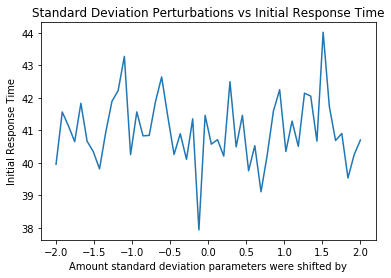

In [69]:
import matplotlib.pyplot as plt
plt.plot(std_adjusts, mec_avgs_mean1 )
print(mean(mec_avgs_mean1))
plt.xlabel("Amount standard deviation parameters were shifted by")
plt.ylabel("Initial Response Time")
plt.title("Standard Deviation Perturbations vs Initial Response Time")

141.69548894393927


Text(0.5, 1.0, 'Standard Deviation Perturbations vs Copier Delivery Times')

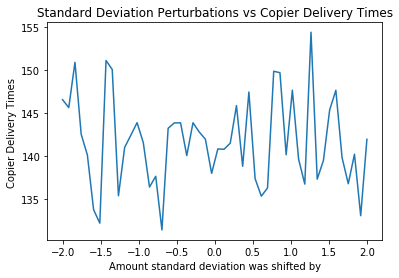

In [70]:
plt.plot(std_adjusts, van_avgs_mean1 )
print(mean(van_avgs_mean1))
plt.xlabel("Amount standard deviation parameters were shifted by")
plt.ylabel("Copier Delivery Times ")
plt.title("Standard Deviation Perturbations vs Copier Delivery Times")

In [59]:
bc_coords = [[6,10],[4,8],[4,6],[1,6],[1,7],[9,3],[11,3],[9,2],[9,1],[11,1]]
bc_names = ['BC_1', 'BC_2', 'BC_3', 'BC_4', 'BC_5', 'BC_6', 'BC_7', 'BC_8', 'BC_9', 'BC_10']

# bc_list = []
# for i in range(len(bc_coords)):
#     bc_list.append(business_center(bc_names[i], bc_coords[i] , 0, 0, 0))
def getBC():
    BC_prob = np.random.uniform(0,1)
    probabilities = np.array([0.039509, 0.082089, 0.107916, 0.135418, 0.118386, 
                              0.055005, 0.123830, 0.057937, 0.137512, 0.142398])
    return np.random.choice(bc_list, 1, p = probabilities)[0]



#mean and standard errors of the estimates
mec_avgs_mean=[]
mec_se_std=[]
van_avgs_mean=[]
van_se_std=[]
t=50
T=100
B=50
mu1=16.13
mu2=22.15
std1=2.89
std2=5.34
# ****SENSITIVITY ANALYSIS PART****
#Looping Through Perturbed Values 
mu_adjusts=np.linspace(start=-2,stop=2, num=50)
for j in mu_adjusts:
    #copy in function that we want to look at
    #Here we are adjusting the mean of the diagnosis times 
    def diagnosis_Time(bc):
        if bc.name in ['BC_2', 'BC_3', 'BC_9']:
            return 1/60*np.random.normal(mu2+j, std2)
        else: 
            return 1/60*np.random.normal(mu1+j, std1)
    mec_avgs=[]
    van_avgs=[]
    for i in range(B):
        simulationclock = 0
        requestQueue = []
        copierQueue = Queue()
        avail_vans = 3
        num_mechs = 7
        DispatchCenter = dispatch([5,2], avail_vans, num_mechs)
        eventlist = PriorityQueue()
        bc_list = []
        for i in range(len(bc_coords)):
            bc_list.append(business_center(bc_names[i], bc_coords[i] , 0, 0, 0))
        a = NewRequest(0)
        eventlist.put( a )
        time_to_respond_avg = []
        copier_req_times = []
    
        while simulationclock < T:
            e = eventlist.get()
            e.handle()

        mec_avgs.append(np.mean(np.array(time_to_respond_avg)))
        van_avgs.append(np.mean(np.array(copier_req_times)))
    #keep track of mean and se
    mec_avgs_mean.append(np.mean(np.array(mec_avgs)))
    print(np.mean(mec_avgs_mean))
    mec_se_std.append(np.std(np.array(mec_avgs))/np.sqrt(B))
    van_avgs_mean.append(np.mean(np.array(van_avgs)))
    van_se_std.append(np.std(np.array(van_avgs))/np.sqrt(B))

38.63940508416529
38.452428424712664
38.230440859999504
38.649641376990864
38.698482582666486
38.66170820385365
38.656747031400236
38.71760481160717
38.64310562296713
38.62500335080489
38.7028441036071
38.74406948002396
38.61839628756558
38.73410718467689
38.83456777100443
38.85168120697601
38.93077451522391
39.021077024469164
39.03792072735159
39.1586942664775
39.276732660906816
39.28685349716908
39.34546088347152
39.39931885419032
39.59996250533905
39.72889767308307
39.796003049685474
39.85511113241953
39.89821319655604
39.95740943883832
39.98597687860858
40.07625371531906
40.137309980962
40.19829993376534
40.22106786173291
40.31149999026816
40.45213531764043
40.48345139549135
40.50886448997517
40.549158209781226
40.64191515921113
40.698394230592214
40.76146196605463
40.86060801858619
40.92488145422066
40.93535564038146
41.02748442646631
41.04702229952224
41.10114765958345
41.118152794168566


41.118152794168566


Text(0, 0.5, 'Initial Response Time')

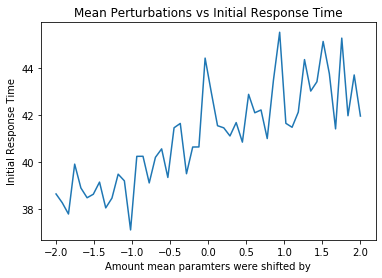

In [71]:
print(np.mean(mec_avgs_mean))
plt.plot(mu_adjusts, mec_avgs_mean )
plt.title("Mean Perturbations vs Initial Response Time")
plt.xlabel("Amount mean paramters were shifted by")
plt.ylabel("Initial Response Time")


142.62349498427818


Text(0, 0.5, 'Copier Delivery Time')

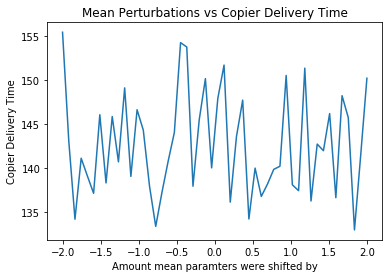

In [72]:
plt.plot(mu_adjusts, van_avgs_mean )
print(mean(van_avgs_mean))
plt.title("Mean Perturbations vs Copier Delivery Time")
plt.xlabel("Amount mean paramters were shifted by")
plt.ylabel("Copier Delivery Time")
